In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

In [4]:
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

In [5]:
# hyperparameters
num_epochs = 50
batch_size = 32
learning_rate = 0.001

In [6]:
# The dataset has PIL images with pixel values of range [0, 1]
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                             download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Displaying some of our images from the dataset.

torch.Size([32, 3, 32, 32]) torch.Size([32])


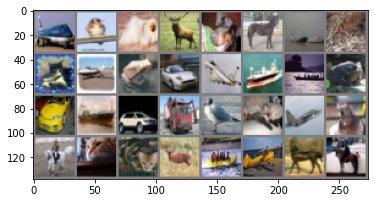

In [8]:
def imshow(img):
  img = img / 2 + 0.5 # unnormalize the image
  npimg = img.numpy() # converting to numpy array
  # changing dimensions from 3, 32, 32 to 32, 32, 3.
  # this is because plt.imshow accepts img as row, column, channel.
  plt.imshow(np.transpose(npimg, (1, 2, 0)))  
  plt.show()

examples = iter(train_loader)
images, labels = next(examples)
print(images.shape, labels.shape)

imshow(torchvision.utils.make_grid(images))

Our model's architecture -
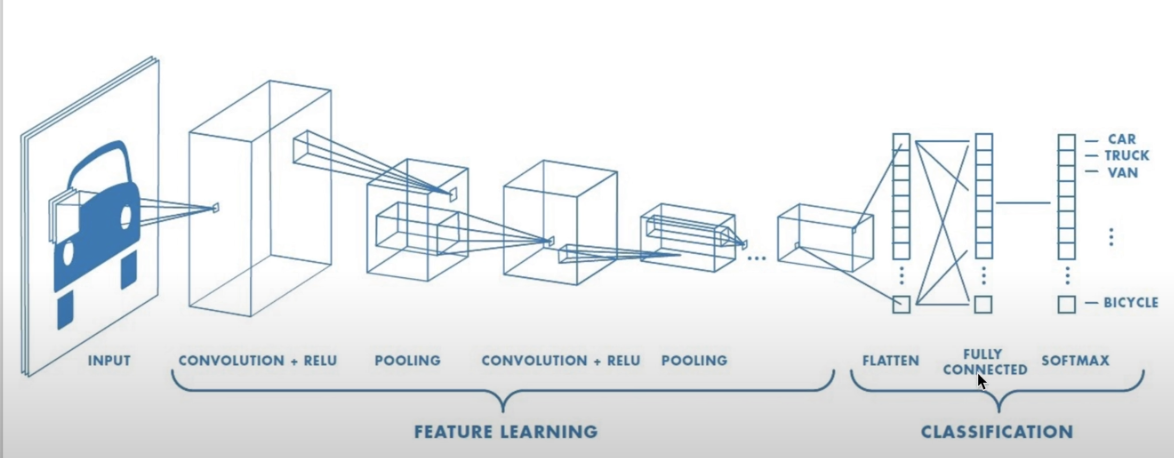

All conv2d layers have filter size 5x5 and all maxpool2d layers have filter size 2x2 with stride 2. The filters also have 3 channels in the first conv layer because our images have 3 channels.

Our image has shape 3x32x32.

In the first conv layer, we are using 6 filters. We get 6 feature maps having a single channel as output. It's shape is 32-5+1 = 6x28x28.

Applying maxpooling with stride 2, we reshape our feature maps to 6x14x14.

In the 2nd conv layer, we are using 16 filters. This results in 16 feature maps each having 1 channel and dimension 14-5+1 = 16x10x10.

After applying another maxpooling layer with stride 2, filter 2x2, our image shape becomes 16x5x5.

We then flatten this 16x5x5 feature map and pass it into the ANN.

The ANN has 120 layers in it's hidden layer 1, 84 layers in it's hidden layer 2 and finally 10 layers in it's output layer.

In [9]:
# defining our model now-
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5) # 3 input channels, 6 output channels, 5x5 kernel, stride 0, padding 0
    self.pool = nn.MaxPool2d(2, 2)  # kernel size 2x2, stride 2
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 120) # 16x5x5 inputs and 120 nodes
    self.fc2 = nn.Linear(120, 84) # hidden layer 2
    self.fc3 = nn.Linear(84, 10)  # 10 outputs for 10 classes.

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16*5*5)  # -1 for the batch size.
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
    # no activation function at the end because it's already in the loss function

model = ConvNet().to(device)

In [10]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# training loop
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
  for index, (images, labels) in enumerate(train_loader):
    # moving data to GPU if available.
    images = images.to(device)
    labels = labels.to(device)

    # forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # printing info
    if (index+1)%200 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Step [{index+1}/{n_total_steps}], loss = {loss.item():.4f}')

print("Finished Training!")


Epoch [1/50], Step [200/1563], loss = 2.0165
Epoch [1/50], Step [400/1563], loss = 1.5391
Epoch [1/50], Step [600/1563], loss = 1.5742
Epoch [1/50], Step [800/1563], loss = 1.6256
Epoch [1/50], Step [1000/1563], loss = 1.9034
Epoch [1/50], Step [1200/1563], loss = 1.3258
Epoch [1/50], Step [1400/1563], loss = 1.1779
Epoch [2/50], Step [200/1563], loss = 1.3649
Epoch [2/50], Step [400/1563], loss = 1.3065
Epoch [2/50], Step [600/1563], loss = 1.2029
Epoch [2/50], Step [800/1563], loss = 1.1296
Epoch [2/50], Step [1000/1563], loss = 1.1168
Epoch [2/50], Step [1200/1563], loss = 1.2222
Epoch [2/50], Step [1400/1563], loss = 1.1701
Epoch [3/50], Step [200/1563], loss = 1.1703
Epoch [3/50], Step [400/1563], loss = 1.5446
Epoch [3/50], Step [600/1563], loss = 1.4292
Epoch [3/50], Step [800/1563], loss = 1.0200
Epoch [3/50], Step [1000/1563], loss = 1.2050
Epoch [3/50], Step [1200/1563], loss = 1.2977
Epoch [3/50], Step [1400/1563], loss = 1.2605
Epoch [4/50], Step [200/1563], loss = 1.2364
E

In [15]:
# testing loop
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]  # Creating a list with 10 zeros.
    n_class_samples = [0 for i in range(10)]  # Creating a list with 10 zeros.
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(labels.shape[0]):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 60.68 %
Accuracy of plane: 63.0 %
Accuracy of car: 75.8 %
Accuracy of bird: 55.3 %
Accuracy of cat: 41.8 %
Accuracy of deer: 55.2 %
Accuracy of dog: 43.4 %
Accuracy of frog: 67.6 %
Accuracy of horse: 68.0 %
Accuracy of ship: 72.4 %
Accuracy of truck: 64.3 %
